**1. Скачивание данных.**

Скачиваем отзывы о театральных постановках.

In [78]:
from fake_useragent import UserAgent
import requests
from bs4 import BeautifulSoup
from tqdm.auto import tqdm

import pandas as pd

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer

from collections import Counter

from sklearn.metrics import accuracy_score

In [79]:
ua = UserAgent(verify_ssl=False)

In [80]:
session = requests.session()

Создаём dataframe для наших отзывов (мне удобнее, когда промежуточный результат будет именно в таком формате).

In [177]:
df_review = pd.DataFrame({'grade': [], 'review': []})

**Что делают следующие функции:**

-parse_one_performance скачивает отзывы со страницы спектакля, учитывая общую оценку (отрицательные — 1-2 звезды и меньше, положительные — 4-5 звёзд).

-parse_performance_page_block достаёт ссылку на новость, смотрит на оценку спектакля, если она ниже трёх с половиной, то ищем отрицательные, в ином случае положительные.

-get_nth_page разбивает страницу на спектакли, объединяет две предыдущие функции.
-run_all прогоняет по номерам страниц и записывает все отзывы с их оценкой в dataframe.

Ещё стоит отметить, что выбирала я только те отзывы, в которых больше 10 слов. Они должны быть более репрезентативными.

Если что-то не получалось, то ошибки записывала в текстовый файл (хотя особо информации это не несёт).

Не знала точно, сколько получится выкачать отзывов, поэтому взяла с запасом 80 страниц. Так скачала по 110 отзывов каждого типа.

In [82]:
def parse_performance_page_block(one_block):
    block = {}
    a = one_block.find('a')
    block['href'] = a.attrs['href']
    grade = one_block.find('div', {'class': 'cifra'}).text
    if float(grade) <= 3.5:
        block['grade'] = 'negative'
    else:
        block['grade'] = 'positive' 

    return block

In [83]:
def parse_one_performance(block):
    url_one = block['href']
    req = session.get(url_one, headers={'User-Agent': ua.random})
    page = req.text
    soup = BeautifulSoup(page, 'html.parser')
    reviews = soup.find_all('div', {'class': 'element-item 1'})
    
    reviews_text = []
    for i in reviews:
        rating = i.find('span', itemprop='reviewRating')
        rating_grade = rating.find(itemprop='ratingValue') #сколько звёзд поставил пользователь
        if block['grade'] == 'negative':
            if int(str(rating_grade)[15]) <= 2:
                review = i.find('div', {'class': 'text mytext'}).text
                if len(word_tokenize(review)) >= 10:
                    reviews_text.append(review)
        else:
            if int(str(rating_grade)[15]) > 3:
                review = i.find('div', {'class': 'text mytext'}).text
                if len(word_tokenize(review)) >= 10:
                    reviews_text.append(review)
        
        block['reviews'] = reviews_text
        return block


In [84]:
def get_nth_page(page_number):

    url = f'https://teatrow.ru/msk/page/{page_number}/'
    req = session.get(url, headers={'User-Agent': ua.random})
    page = req.text
    soup = BeautifulSoup(page, 'html.parser')
    performances = soup.find_all('div', {'class': 'box_in block_info'})

    blocks = []
    for n in performances:
        try:
            blocks.append(parse_performance_page_block(n))
        except Exception as e:
            with open('Errors.txt', 'a', encoding='utf-8') as f:
                error = ' '.join([str(e), 'Ссылка на страницу:', url, '\n'])
                f.write(error)


    result = []
    for b in blocks:  
        try:
            res = parse_one_performance(b)
            result.append(res)
        except Exception as e:
            with open('Errors.txt', 'a', encoding='utf-8') as f:
                error = ' '.join([str(e), 'Ссылка на страницу:', url, '\n'])
                f.write(error)
            
    return result

In [85]:
def run_all(n_pages):
    positive = 0
    negative = 0
    for i in tqdm(range(n_pages)):
        try: #на странице 50, кажется, у меня возникла проблема с тем, чтобы получить ссылку поэтому я решила и сюда добавить try except
            blocks = get_nth_page(i+1)
            for block in blocks:
                if block['grade'] == 'positive' and positive <=110:
                    for i in block['reviews']:
                        df_review.loc[len(df_review.index)] = [block['grade'], i]
                        positive+=1
                elif block['grade'] == 'negative' and negative <=110:
                    for i in block['reviews']:
                        df_review.loc[len(df_review.index)] = [block['grade'], i]
                        negative+=1
        except Exception as e:
            with open('Errors.txt', 'a', encoding='utf-8') as f:
                error = ' '.join([str(e), 'проблема с сылкой на страницу', '\n'])
                f.write(error)
            
    return df_review   

In [86]:
run_all(80)

  0%|          | 0/80 [00:00<?, ?it/s]

,grade,review
0,positive,Замечательный мюзикл. Прекрасно провели время....
1,positive,пойду снова в третий раз !!!!!
2,positive,Как будто попал 1990 лет назад или 33 год наше...
3,positive,Спектакль очень понравился! Замечательная музы...
4,positive,Я просто полностью погрузился в атмосферу спек...
...,...,...
217,negative,От Стриндберга осталось чуть больше половины. ...
218,negative,"Выскажу сугубо свое мнение: тем, кто смотрел г..."
219,negative,были 30.09.2019. замечательно! на дам-чиповск...
220,negative,Ушли после первого акта. Юмор дешёвого стендап...


Чтобы вновь не тратить много времени на скачивание, загрузим всё в csv

In [173]:
df_review.to_csv (r'df_review.csv', index= False )

Когда я ставила ограничение на 10 слов, я не думала, что может стоять много знаков препинания (!), которые могут посчитать за один токен. В результате есть несколько (совсем мало) отзывов, где слов мало, но много знаков препинания. Так как таких отзывов всё-таки малое количество, то я их решила не убирать и оставить всё как есть.

**2. Токенизируйте слова, приведите их к нижнему регистру и к начальной форме.**

Для того, чтобы привести слова к начальной форме, воспользуюсь pymorphy. На этом же шаге я решила избавиться от стоп-слов, так как они не влияют на тональность текста.

In [178]:
df_review = pd.read_csv('df_review.csv')

In [179]:
morph = MorphAnalyzer()
sw = stopwords.words('russian')

Выбираем случайные отзывы для теста и удаляем по индексу эти строки из основной таблицы

In [180]:
df_pos = df_review[(df_review['grade'] == 'positive')]
df_pos_test = df_pos.sample(n=10)

df_neg = df_review[(df_review['grade'] == 'negative')]
df_neg_test = df_neg.sample(n=10) 

df_test = pd.concat([df_neg_test, df_pos_test])

index = df_test.index.tolist ()
df_review.drop(labels = index, axis = 0, inplace = True)

Здесь я прохожусь по каждому отзыву, смотрю какой он и токенизирую, привожу слова к нижнему регистру и начальной форме. Тут же удаляю стоп-слова и убираю пунктуацию, так как нам нужны множества *слов*.

In [181]:
words_negative_reviews = []
words_positive_reviews = []

for i, row in tqdm(df_review.iterrows()): #просто понимать, идёт ли обработка отзывов или нет
    if row['grade'] == 'negative':
        work_review = [w.lower() for w in word_tokenize(row['review']) if w.isalpha()]
        for token in work_review:
            word_morph = morph.parse(token)
            if word_morph[0].normal_form not in sw:
                words_negative_reviews.append(word_morph[0].normal_form)
    else:
        work_review = [w.lower() for w in word_tokenize(row['review']) if w.isalpha()]
        for token in work_review:
            word_morph = morph.parse(token)
            if word_morph[0].normal_form not in sw:
                words_positive_reviews.append(word_morph[0].normal_form) 

0it [00:00, ?it/s]

**3. Составьте 2 множества - в одном будут слова, которые встречаются только в положительных отзывах, а в другом - встречающиеся только в отрицательных.**

Тут я исключаю те слова, что встречаются по одному разу лишь и создаю два множества и беру из каждого всё, кроме их пересечения (чтобы были только уникальные для каждого типа отзывов слова).

In [182]:
both_dicts = {}

In [183]:
freqlist = Counter()
for word in words_negative_reviews:
    freqlist[word] += 1
dict_negative_reviews = dict(freqlist)
both_dicts['negative'] = dict_negative_reviews

freqlist = Counter()
for word in words_positive_reviews:
    freqlist[word] += 1
dict_positive_reviews = dict(freqlist)
both_dicts['positive'] = dict_positive_reviews

In [184]:
most_freq_neg = []

for element in both_dicts['negative']:
    if dict_negative_reviews[element] > 2:
        most_freq_neg.append(element)

most_freq_pos = []
for element in both_dicts['positive']:
    if dict_positive_reviews[element] > 2:
        most_freq_pos.append(element)

In [185]:
neg = set(most_freq_neg)
pos = set(most_freq_pos)
neg_pos = set.intersection(neg, pos)

In [186]:
neg.symmetric_difference_update(neg_pos)
pos.symmetric_difference_update(neg_pos)

**4. Создайте функцию, которая будет определять, положительный ли отзыв или отрицательный в зависимости от того, какие слова встретились в нём, и посчитайте качество при помощи accuracy.**

Эта функция определяет тональность.

In [265]:
def pos_or_neg(set_pos, set_neg, review_input):

    positive = 0
    negative = 0
    for word in word_tokenize(review_input):
        word_morph = morph.parse(word)
        if word_morph[0].normal_form in set_pos:
            positive+= 1
        if word_morph[0].normal_form in set_neg:
            negative+= 1
            
    if positive > negative:
        return 'positive'
    else:
        return 'negative'

А эта считает качество.

In [266]:
def test_tone_detect(set_pos, set_neg, df_test):
    results = []
    origin = []
    
    for i, row in df_test.iterrows():
        predicted_tone = pos_or_neg(set_pos, set_neg, row['review'])
        results.append(predicted_tone)

        origin.append(row['grade'])

    print(f'result: {accuracy_score(results, origin)}')

In [267]:
test_tone_detect(pos, neg, df_test)

result: 0.65


Да, итог получился не прям хорошим, но это больше половины!

**5. Предложите как минимум 2 способа улучшить этот алгоритм определения тональности отзыва.**

*Способ нумер раз-с:*

Изначально, когда мы составляем тональный словарь, чем чаще встречается слово, тем больший вес ему можем дать. В тот момент, когда мы будем определять, какой же всё-таки по тональности отзыв, мы будем смотреть на вес слова и на разницу в значениях между "положительными" словами и "отрицательными". 

Пример: пускай слово "ужасный" встречается очень много раз и будет иметь вес x, а вот слово "неплохо" реже (вес y, x>y). Оба этих слова встречаются в рассматриваемом отзыве. Разница между количеством "положительных" и "отрицательных" слов небольшая или её вовсе нет (1 положительное и 1 отрицательное). Однако есть сильное "отрицательное" слово, которое перевесит в сторону отрицательной тональности. Таким образом, алгоритм будет работать чуть лучше.

В качестве весов можно сделать значение Tf-Idf. Посчитаем метрику и получим матрицу, где строками будут отзывы, а столбцами слова. Суммировав все значения в одном столбце мы получим вес слова, который будет отвечать за что-то типо важности.

In [268]:
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.tokenize import wordpunct_tokenize

In [269]:
tfidf = TfidfVectorizer(
    analyzer = 'word',
    stop_words = sw
)

In [270]:
all_reviews = []

for i, row in tqdm(df_review.iterrows()):
    review_tokens = wordpunct_tokenize(row['review'])
    review_lemmatized = " ".join([morph.parse(item)[0].normal_form for item in review_tokens])
    negative_reviews_preprocessed.append(review_lemmatized)
    all_reviews.append(review_lemmatized)

0it [00:00, ?it/s]

In [271]:
review_tfidf = tfidf.fit_transform(all_reviews)

In [272]:
matrix_review = pd.DataFrame(review_tfidf.toarray(), columns=tfidf.get_feature_names_out())

При первичной обработке у нас есть уже частотный словарь и списки. Ими мы и воспользуемся.

In [273]:
dict_neg = {}
for i in most_freq_neg:
    dict_neg[i] = matrix_review[i].sum()
    
dict_pos = {}
for i in most_freq_pos:
    dict_pos[i] = matrix_review[i].sum()
    
dict_tone_tfidf = {
    'neg': dict_neg,
    'pos': dict_pos
}

In [274]:
def pos_or_neg_tfidf(dict_tone_tfidf, review_input):
    
    positive = 0
    negative = 0
    for word in word_tokenize(review_input):
        word_morph = morph.parse(word)
        if word_morph[0].normal_form in dict_tone_tfidf['pos']:
            positive+= dict_tone_tfidf['pos'][word_morph[0].normal_form]
        if word_morph[0].normal_form in dict_tone_tfidf['neg']:
            negative+= dict_tone_tfidf['neg'][word_morph[0].normal_form]
            
    if positive > negative:
        return 'positive'
    else:
        return 'negative'

In [275]:
def test_tone_detect_tfidf(dict_tone_tfidf, df_test):
    results = []
    origin = []
    
    for i, row in df_test.iterrows():
        predicted_tone = pos_or_neg_tfidf(dict_tone_tfidf, row['review'])
        results.append(predicted_tone)

        origin.append(row['grade'])

    print(f'result: {accuracy_score(results, origin)}')

In [276]:
test_tone_detect_tfidf(dict_tone_tfidf, df_test)

result: 0.7


Уже 0.7! На целых 5 сотых больше. На мой взгляд, это точно говорит об улучшении алгоритма!

*Способ нумер два-с:*

Воспользуемся семантической близостью слов. На основе наших отзывов можно построить модель в word2vec, таким образом у каждого слова будет свой вектор. Когда мы будем определять тональность отзыва и какого-то слова не будет в частотном списке слов, то мы будем смотреть на похожие слова. 

Пример: слово "годный" не встречается в частотном списке, так как встретилось лишь один раз, но мы можем найти похожие слова с помощью most_similar. Если что-то из топ-5 входит в частотный спислк, тот мы добавим балл в копилку отрицательной тональности. 

Тут мне кажется, можно давать 2 пункта, если слово было в частотном списке как есть и 1 пункт, если мы его отнесли к какому-то виду через поиск похожих слов.

In [287]:
from nltk.tokenize import sent_tokenize
import re

import gensim
import logging
import urllib.request

import warnings
warnings.filterwarnings('ignore')

В предыдущем дополнении к алгоритму мы собрали все тексты в all_review. В этом же способе мы их возьмём, так как они уже приведены к нижнему региструу и т.д.

In [286]:
for review in all_reviews:
    sentences_in_review = sent_tokenize(review)
    with open('reviews.txt', mode='a', encoding='utf-8') as file_result:
        for sentence in sentences_in_review:
            sentence_no_punct = re.sub(r'[^\w\s]','', sentence) 
            if sentence_no_punct != '':
                file_result.write(sentence_no_punct+'\n')

In [288]:
file_obuch = 'reviews.txt'
data = gensim.models.word2vec.LineSentence(file_obuch)

model_review = gensim.models.Word2Vec(data, window=5, vector_size=300, epochs = 50)

В первом алгоритме мы использовали уже множества "отрицательных" и "положительных" слов. Ими мы и воспользуемся сейчас.

In [311]:
def pos_or_neg_word2vec(set_pos, set_neg, review_input):
    
    positive = 0
    negative = 0
    for word in word_tokenize(review_input):
        word_morph = morph.parse(word)
        if word_morph[0].normal_form in set_pos:
            positive+= 2
        elif word_morph[0].normal_form in list(model_review.wv.index_to_key):
            sim_words = model_review.wv.most_similar(positive = [word_morph[0].normal_form], topn=5)
            for i in sim_words:
                if i in set_pos:
                    positive+= 1
             
        if word_morph[0].normal_form in set_neg:
            negative+= 2
        elif word_morph[0].normal_form in list(model_review.wv.index_to_key):
            sim_words = model_review.wv.most_similar(positive = [word_morph[0].normal_form], topn=5)
            for i in sim_words:
                if i in set_neg:
                    negative+= 1
            
    if positive > negative:
        return 'positive'
    else:
        return 'negative'

In [312]:
def test_tone_detect_word2vec(set_pos, set_neg, df_test):
    results = []
    origin = []
    
    for i, row in df_test.iterrows():
        predicted_tone = pos_or_neg_word2vec(set_pos, set_neg, row['review'])
        results.append(predicted_tone)

        origin.append(row['grade'])

    print(f'result: {accuracy_score(results, origin)}')

In [313]:
test_tone_detect_word2vec(pos, neg, df_test)

result: 0.65


Ну, это не получилось сделать прям улучшением алгоритма, но оно не сделало алгоритм хуже! Что тоже является успехом. Наверное, на большей выборке это могло бы сработать.

А вообще, наверное, следовало бы брать отзывы только на один спектакль. Выбрать какой-то очень масштабный из топа и на его основе сделать выборку. Однако я подумала, что не скачаю достаточное количество отзывов каждого вида.

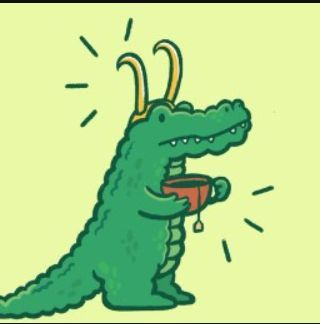